<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/vae_celeba_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Variational) Convolutional Autoencoder for CelebA and Mnist

Code uses TF 2.0 idioms and should work with images of any size and number of channels. Code is based on various sources, including
- https://www.tensorflow.org/beta/tutorials/generative/cvae.
- https://github.com/davidADSP/GDL_code/blob/master/03_03_vae_digits_train.ipynb








# Import TensorFlow and other libraries

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices("GPU"):
    print("No GPU was detected. DNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

In [2]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display
import sklearn

# from time import time

np.random.seed(0)

# Load CelebA

Here we download a zipfile of images and their attributes
that have been preprocessed to 64x64 using the script at
https://github.com/probml/pyprobml/blob/master/scripts/celeba_kaggle_preprocess.py



In [3]:
# N can be 200, 20000, or 40000
N = 20000
H = 64
W = 64
C = 3
input_shape = [H, W, 3]
name = "celeba_small_H{}_W{}_N{}".format(H, W, N)
csv_name = "{}.csv".format(name)
zip_name = "{}.zip".format(name)

In [4]:
!rm {csv_name}
!wget https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/{csv_name}

rm: cannot remove 'celeba_small_H64_W64_N20000.csv': No such file or directory
--2021-06-22 21:39:14--  https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/celeba_small_H64_W64_N20000.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2440084 (2.3M) [text/plain]
Saving to: ‘celeba_small_H64_W64_N20000.csv’

celeba_small_H64_W6 100%[===================>]   2.33M  --.-KB/s    in 0.06s   

2021-06-22 21:39:14 (38.8 MB/s) - ‘celeba_small_H64_W64_N20000.csv’ saved [2440084/2440084]



In [5]:
import pandas as pd

df = pd.read_csv(csv_name)
df.head()

image_id  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  000001.jpg                -1  ...               -1      1
1  000002.jpg                -1  ...               -1      1
2  000003.jpg                -1  ...               -1      1
3  000004.jpg                -1  ...               -1      1
4  000005.jpg                -1  ...               -1      1

[5 rows x 41 columns]

In [6]:
print(list(df.columns))

['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [7]:
N = len(df)
print(N)

20000


In [8]:
!rm {zip_name}
!wget https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/{zip_name}

rm: cannot remove 'celeba_small_H64_W64_N20000.zip': No such file or directory
--2021-06-22 21:39:15--  https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/celeba_small_H64_W64_N20000.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34148268 (33M) [application/zip]
Saving to: ‘celeba_small_H64_W64_N20000.zip’

celeba_small_H64_W6 100%[===================>]  32.57M   122MB/s    in 0.3s    

2021-06-22 21:39:17 (122 MB/s) - ‘celeba_small_H64_W64_N20000.zip’ saved [34148268/34148268]



In [9]:
!rm *.jpg
!ls

rm: cannot remove '*.jpg': No such file or directory
celeba_small_H64_W64_N20000.csv  celeba_small_H64_W64_N20000.zip  sample_data


In [10]:
!unzip -qq {zip_name}

In [11]:
from glob import glob

filenames = glob("*.jpg")
# print(filenames) # should match df['image_id']
print(len(filenames))

20000


In [12]:
from matplotlib.image import imread

images_celeba = np.zeros((N, H, W, C), dtype=np.float32)  # pre-allocate memory
for i in range(N):
    filename = df.iloc[i]["image_id"]
    img = imread(filename)  # numpy array of uint8
    images_celeba[i, :, :, :] = img / 255  # float in 0..1

In [13]:
BATCH_SIZE = 32

# make this into a labeled dataset to match mnist
def add_dummy_label(sample):
    img = sample
    label = -1
    return img, label


dataset_celeba = tf.data.Dataset.from_tensor_slices(images_celeba)
train_dataset_celeba = dataset_celeba.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e3))

test_dataset_celeba = train_dataset_celeba
num_colors = 3

# Load MNIST

In [14]:
dataname = "mnist"
# dataname = 'fashion_mnist'
# dataname = 'cifar10' # https://www.tensorflow.org/datasets/catalog/cifar10

datasets, datasets_info = tfds.load(name=dataname, with_info=True, as_supervised=False)
print(datasets_info)

input_shape = datasets_info.features["image"].shape
print(input_shape)
num_colors = input_shape[2]

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

(28, 28, 1)


In [15]:
batchsize = 64
# We assume the dataset has a dict of features called image and label.
# We extract the image from the dict, and scale each channel to [0,1]
# We return a tuple (rescaled-image, label).


def scale_pixels_and_keep_label(sample):
    img = tf.cast(sample["image"], tf.float32) / 255.0  # Scale to unit interval.
    label = sample["label"]
    return img, label


def scale_pixels_and_drop_label(sample):
    img = tf.cast(sample["image"], tf.float32) / 255.0  # Scale to unit interval.
    label = sample["label"]
    return img


train_dataset_mnist = (
    datasets["train"]
    .map(scale_pixels_and_drop_label)
    .batch(batchsize)
    .prefetch(tf.data.experimental.AUTOTUNE)
    .shuffle(int(10e3))
)

test_dataset_mnist = (
    datasets["test"].map(scale_pixels_and_drop_label).batch(batchsize).prefetch(tf.data.experimental.AUTOTUNE)
)

test_dataset_mnist_labeled = (
    datasets["test"].map(scale_pixels_and_keep_label).batch(batchsize).prefetch(tf.data.experimental.AUTOTUNE)
)

In [16]:
B = test_dataset_mnist.take(1)
print(B)

B = test_dataset_mnist_labeled.take(1)
print(B)

<TakeDataset shapes: (None, 28, 28, 1), types: tf.float32>
<TakeDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


In [17]:
test_ds_unlabeled = tfds.as_numpy(datasets["test"].map(scale_pixels_and_drop_label))
L = list(test_ds_unlabeled)  # force the generator to yield
images_np = np.stack(L, axis=0)  # 10k, 28, 28, 1
print(images_np.shape)

(10000, 28, 28, 1)


In [18]:
test_ds = tfds.as_numpy(datasets["test"].map(scale_pixels_and_keep_label))
L = list(test_ds)  # force the generator to yield
X, y = L[0]
N = len(L)
H, W, C = X.shape
images_mnist = np.zeros((N, H, W, C), dtype=np.float32)  # pre-allocate memory
labels_mnist = np.zeros(N)
for i in range(N):
    X, y = L[i]
    images_mnist[i, :, :, :] = X
    labels_mnist[i] = y
print(images_mnist.shape)

(10000, 28, 28, 1)


# Inspect TFDS dataset

In [19]:
def inspect_tfds(iterator, nbatches=3, is_labeled=False):
    i = 0
    max_batch = 2
    for batch in iterator:
        if is_labeled:
            X, y = batch
            print("batch#{}, X size {}, Y size {}".format(i, X.shape, y.shape))
        else:
            X = batch
            print("batch#{}, X size {}".format(i, X.shape))
        i += 1
        if i >= nbatches:
            break


inspect_tfds(test_dataset_celeba)
inspect_tfds(test_dataset_mnist)
inspect_tfds(test_dataset_mnist_labeled, is_labeled=True)

batch#0, X size (32, 64, 64, 3)
batch#1, X size (32, 64, 64, 3)
batch#2, X size (32, 64, 64, 3)
batch#0, X size (64, 28, 28, 1)
batch#1, X size (64, 28, 28, 1)
batch#2, X size (64, 28, 28, 1)
batch#0, X size (64, 28, 28, 1), Y size (64,)
batch#1, X size (64, 28, 28, 1), Y size (64,)
batch#2, X size (64, 28, 28, 1), Y size (64,)


In [20]:
def extract_from_tfds(iterator, N=4, is_labeled=False):
    batch = iterator.take(1)
    first_batch = list(batch)
    if is_labeled:
        X, y = first_batch[0]
        Xsmall = X[:N]
        ysmall = y[:N]
        return Xsmall, ysmall
    else:
        X = first_batch[0]
        Xsmall = X[:N]
        return Xsmall


Xsmall_celeba = extract_from_tfds(train_dataset_celeba)
Xsmall_mnist = extract_from_tfds(train_dataset_mnist)
XX, yy = extract_from_tfds(test_dataset_mnist_labeled, is_labeled=True)
print(XX.shape)
print(yy.shape)

(4, 28, 28, 1)
(4,)


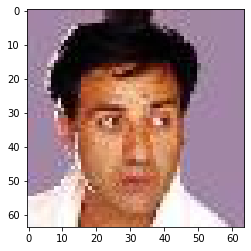

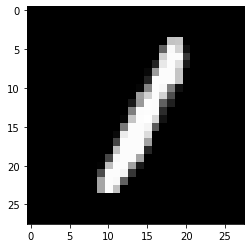

In [21]:
def imshow2(img):
    H, W, C = img.shape
    if C == 1:
        plt.imshow(img[:, :, 0], cmap="gray")
    else:
        plt.imshow(img[:, :, :])
    plt.show()


imshow2(Xsmall_celeba[0, :])
imshow2(Xsmall_mnist[0, :])

# Define model

In [22]:
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    Flatten,
    Dense,
    Conv2DTranspose,
    Reshape,
    Lambda,
    Activation,
    BatchNormalization,
    LeakyReLU,
    Dropout,
)
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [23]:
def make_encoder(
    input_dim,
    z_dim,
    encoder_conv_filters,
    encoder_conv_kernel_size,
    encoder_conv_strides,
    use_batch_norm=False,
    use_dropout=False,
    autoencoder=False,
):
    encoder_input = Input(shape=input_dim, name="encoder_input")
    x = encoder_input
    n_layers_encoder = len(encoder_conv_filters)
    for i in range(n_layers_encoder):
        conv_layer = Conv2D(
            filters=encoder_conv_filters[i],
            kernel_size=encoder_conv_kernel_size[i],
            strides=encoder_conv_strides[i],
            padding="same",
            name="encoder_conv_" + str(i),
        )
        x = conv_layer(x)
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        if use_dropout:
            x = Dropout(rate=0.25)(x)
    shape_before_flattening = K.int_shape(x)[1:]
    x = Flatten()(x)
    mu = Dense(z_dim, name="mu")(x)  # no activation
    if autoencoder:
        encoder = Model(encoder_input, mu)
    else:
        log_var = Dense(z_dim, name="log_var")(x)  # no activation
        encoder = Model(encoder_input, (mu, log_var))
    return encoder, shape_before_flattening

In [24]:
def make_encoder_test_helper(Xsmall, latent_dim=2, autoencoder=False):
    N, H, W, C = Xsmall.shape
    input_dim = (H, W, C)
    encoder, shape_before_flattening = make_encoder(
        input_dim=input_dim,
        encoder_conv_filters=[32, 64],
        encoder_conv_kernel_size=[3, 3],
        encoder_conv_strides=[2, 2],
        z_dim=latent_dim,
        autoencoder=autoencoder,
    )
    return encoder, shape_before_flattening


def test_encoder():
    latent_dim = 2
    for Xsmall in [Xsmall_celeba, Xsmall_mnist]:
        encoder, shape_before_flattening = make_encoder_test_helper(Xsmall, latent_dim, autoencoder=False)
        print(encoder.summary())
        Hz, Wz, Cz = shape_before_flattening
        N, H, W, C = Xsmall.shape
        M, V = encoder(Xsmall)
        assert M.shape == (N, latent_dim)
        assert Cz == 64  # number of filters we chose for embedding


test_encoder()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 16, 16, 64)   18496       leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [25]:
def make_decoder(
    shape_before_flattening,
    z_dim,
    decoder_conv_t_filters,
    decoder_conv_t_kernel_size,
    decoder_conv_t_strides,
    use_batch_norm=False,
    use_dropout=False,
):
    decoder_input = Input(shape=(z_dim,), name="decoder_input")
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)
    n_layers_decoder = len(decoder_conv_t_filters)
    for i in range(n_layers_decoder):
        conv_t_layer = Conv2DTranspose(
            filters=decoder_conv_t_filters[i],
            kernel_size=decoder_conv_t_kernel_size[i],
            strides=decoder_conv_t_strides[i],
            padding="same",
            name="decoder_conv_t_" + str(i),
        )
        x = conv_t_layer(x)
        if i < n_layers_decoder - 1:
            if use_batch_norm:
                x = BatchNormalization()(x)
            x = LeakyReLU()(x)
            if use_dropout:
                x = Dropout(rate=0.25)(x)
        # No activation fn in final layer since returns logits
        # else:
        #    x = Activation('sigmoid')(x)
    decoder_output = x
    decoder = Model(decoder_input, decoder_output)
    return decoder

In [26]:
def make_decoder_test_helper(Xsmall, shape_before_flattening, latent_dim=2):
    N, H, W, C = Xsmall.shape
    decoder = make_decoder(
        shape_before_flattening,
        decoder_conv_t_filters=[64, 32, C],
        decoder_conv_t_kernel_size=[3, 3, 3],
        decoder_conv_t_strides=[2, 2, 1],
        z_dim=latent_dim,
    )
    return decoder


def test_decoder():
    latent_dim = 2
    for Xsmall in [Xsmall_celeba, Xsmall_mnist]:
        encoder, shape_before_flattening = make_encoder_test_helper(Xsmall, latent_dim, autoencoder=True)
        decoder = make_decoder_test_helper(Xsmall, shape_before_flattening, latent_dim)
        print(decoder.summary())
        Hz, Wz, Cz = shape_before_flattening
        N, H, W, C = Xsmall.shape
        Z = np.random.randn(N, latent_dim).astype(np.float32)
        Z = encoder(Xsmall)
        assert Z.shape == (N, latent_dim)
        Xrecon = decoder(Z)
        print(Xrecon.shape)
        print(Xsmall.shape)
        assert Xrecon.shape == Xsmall.shape


test_decoder()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 16384)             49152     
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 64, 64, 32)        18464     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64, 64, 32)        0   

In [27]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def sample_gauss(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * 0.5) + mean

In [28]:
class ConvVAE(tf.keras.Model):
    def __init__(
        self,
        input_dim,
        latent_dim,
        encoder_conv_filters,
        encoder_conv_kernel_size,
        encoder_conv_strides,
        decoder_conv_t_filters,
        decoder_conv_t_kernel_size,
        decoder_conv_t_strides,
        use_batch_norm=False,
        use_dropout=False,
        recon_loss_scaling=1,
        kl_loss_scaling=1,
        use_mse_loss=False,
        autoencoder=False,
        model_name=None,
    ):
        super(ConvVAE, self).__init__()
        # Save all args so we can reconstruct this object later
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        self.recon_loss_scaling = recon_loss_scaling
        self.kl_loss_scaling = kl_loss_scaling
        self.use_mse_loss = use_mse_loss
        self.autoencoder = autoencoder
        self.nepochs = 0
        if model_name:
            self.model_name = model_name
        else:
            model_name = "det{}_dim{}".format(autoencoder, latent_dim)
            self.model_name = model_name

        self.inference_net, self.shape_before_flattening = make_encoder(
            input_dim,
            latent_dim,
            encoder_conv_filters,
            encoder_conv_kernel_size,
            encoder_conv_strides,
            use_batch_norm,
            use_dropout,
            autoencoder,
        )

        self.generative_net = make_decoder(
            self.shape_before_flattening,
            latent_dim,
            decoder_conv_t_filters,
            decoder_conv_t_kernel_size,
            decoder_conv_t_strides,
            use_batch_norm,
            use_dropout,
        )

    @tf.function
    def sample(self, nsamples=1):
        eps = tf.random.normal(shape=(nsamples, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode_stochastic(self, x):
        if self.autoencoder:
            raise Exception("AE cannot encode stochastically")
        mean, logvar = self.inference_net(x)
        return sample_gauss(mean, logvar)

    def encode(self, x):
        if self.autoencoder:
            return self.inference_net(x)
        mean, logvar = self.inference_net(x)
        return mean

    def decode(self, z, apply_sigmoid=True):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    @tf.function
    def compute_loss(self, x):
        if self.autoencoder:
            z = self.inference_net(x)
        else:
            mean, logvar = self.inference_net(x)
            z = sample_gauss(mean, logvar)
        if self.use_mse_loss:
            x_probs = self.decode(z, apply_sigmoid=True)
            mse = tf.reduce_mean((x - x_probs) ** 2, axis=[1, 2, 3])
            logpx_z = -0.5 * mse  # log exp(-0.5 (x-mu)^2)
        else:
            x_logit = self.decode(z, apply_sigmoid=False)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)  # -sum_{c=0}^1 p_c log q_c
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])  # sum over H,W,C
        if self.autoencoder:
            kl_loss = 0
        else:
            logpz = log_normal_pdf(z, 0.0, 0.0)  # prior: mean=0, logvar=0
            logqz_x = log_normal_pdf(z, mean, logvar)
            kl_loss = logpz - logqz_x  # single sample MC approximation
        return -tf.reduce_mean(self.recon_loss_scaling * logpx_z + self.kl_loss_scaling * kl_loss)  # -ve ELBO

    @tf.function
    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        return gradients

    @tf.function
    def compute_loss_and_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        return loss, gradients

# Create models

In [29]:
# Use parameters from
# https://nbviewer.jupyter.org/github/davidADSP/GDL_code/blob/master/03_05_vae_faces_train.ipynb

encoder_conv_filters = [32, 64, 64, 64]
encoder_conv_kernel_size = [3, 3, 3, 3]
encoder_conv_strides = [2, 2, 2, 2]
decoder_conv_t_filters = [64, 64, 32, 3]
decoder_conv_t_kernel_size = [3, 3, 3, 3]
decoder_conv_t_strides = [2, 2, 2, 2]

N, H, W, C = Xsmall_celeba.shape
input_shape = (H, W, C)

names = ["2d_det", "200d_det", "2d_stoch", "200d_stoch"]
deterministic = [True, True, False, False]
latent_dims = [2, 200, 2, 200]
models_celeba = []
for i in range(4):
    model = ConvVAE(
        input_dim=input_shape,
        latent_dim=latent_dims[i],
        encoder_conv_filters=encoder_conv_filters,
        encoder_conv_kernel_size=encoder_conv_kernel_size,
        encoder_conv_strides=encoder_conv_strides,
        decoder_conv_t_filters=decoder_conv_t_filters,
        decoder_conv_t_kernel_size=decoder_conv_t_kernel_size,
        decoder_conv_t_strides=decoder_conv_t_strides,
        use_batch_norm=True,
        use_dropout=True,
        use_mse_loss=True,
        recon_loss_scaling=10000,
        autoencoder=deterministic[i],
        model_name=names[i],
    )
    print(model)
    models_celeba.append(model)

model_dict_celeba = {}
for model in models_celeba:
    model_dict_celeba[model.model_name] = model

In [30]:
# For MNIST, use parameters from
# https://github.com/davidADSP/GDL_code/blob/master/03_03_vae_digits_train.ipynb

N, H, W, C = Xsmall_mnist.shape
input_shape = (H, W, C)

if 0:
    encoder_conv_filters = [32, 64]
    encoder_conv_kernel_size = [3, 3]
    encoder_conv_strides = [2, 2]
    decoder_conv_t_filters = [64, 32, C]
    decoder_conv_t_kernel_size = [3, 3, 3]
    decoder_conv_t_strides = [2, 2, 1]
else:
    encoder_conv_filters = [32, 64, 64, 64]
    encoder_conv_kernel_size = [3, 3, 3, 3]
    encoder_conv_strides = [1, 2, 2, 1]
    decoder_conv_t_filters = [64, 64, 32, C]
    decoder_conv_t_kernel_size = [3, 3, 3, 3]
    decoder_conv_t_strides = [1, 2, 2, 1]

names = ["2d_det", "20d_det", "2d_stoch", "20d_stoch"]
deterministic = [True, True, False, False]
latent_dims = [2, 20, 2, 20]
models_mnist = []
for i in range(4):
    model = ConvVAE(
        input_dim=input_shape,
        encoder_conv_filters=encoder_conv_filters,
        encoder_conv_kernel_size=encoder_conv_kernel_size,
        encoder_conv_strides=encoder_conv_strides,
        decoder_conv_t_filters=decoder_conv_t_filters,
        decoder_conv_t_kernel_size=decoder_conv_t_kernel_size,
        decoder_conv_t_strides=decoder_conv_t_strides,
        latent_dim=latent_dims[i],
        recon_loss_scaling=1000,
        use_mse_loss=True,
        autoencoder=deterministic[i],
        model_name=names[i],
    )
    print(model)
    models_mnist.append(model)


model_dict_mnist = {}
for model in models_mnist:
    model_dict_mnist[model.model_name] = model

In [31]:
def test_vae(model, Xsmall):
    print("testing {}".format(model.model_name))
    Z = model.encode(Xsmall)
    predictions = model.decode(Z)
    assert predictions.shape == Xsmall.shape
    L = model.compute_loss(Xsmall)
    g = model.compute_gradients(Xsmall)


for model in models_mnist:
    test_vae(model, Xsmall_mnist)

for model in models_celeba:
    test_vae(model, Xsmall_celeba)

testing 2d_det
testing 20d_det
testing 2d_stoch
testing 20d_stoch
testing 2d_det


testing 200d_det


testing 2d_stoch
testing 200d_stoch


# Training


In [32]:
# generic (model agnostic) training function.
# model must support these methods:
# g = model.compute_gradients(X)
# v = model.traininable_variables (so model is a subclass of Keras.Model)


def train_model(model, optimizer, train_dataset, epochs, callback=None, *args):
    start_time = time.time()
    for epoch in range(0, epochs):
        for batch in train_dataset:
            loss, gradients = model.compute_loss_and_gradients(batch)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        if callback:
            callback(model, epoch, loss, batch, *args)
    end_time = time.time()
    elapsed_time = end_time - start_time
    model.nepochs += epochs
    return model, elapsed_time

In [33]:
# Test it!
def callback(model, epoch, loss, batch, a, b):
    # X, y = batch
    X = batch
    print("epoch {}, loss {}, X shape {}, a {}, b {}".format(epoch, loss, X.shape, a, b))


a = 1
b = 2
optimizer = tf.keras.optimizers.Adam(1e-3)
epochs = 1

model = model_dict_mnist["2d_det"]
model = train_model(model, optimizer, train_dataset_mnist, epochs, callback, a, b)

model = model_dict_celeba["2d_stoch"]
model = train_model(model, optimizer, train_dataset_celeba, epochs, callback, a, b)

epoch 0, loss 23.106830596923828, X shape (64, 28, 28, 1), a 1, b 2
epoch 0, loss 211.47850036621094, X shape (32, 64, 64, 3), a 1, b 2


In [34]:
print(model_dict_mnist["2d_det"].nepochs)
print(model_dict_mnist["2d_stoch"].nepochs)

print(model_dict_celeba["2d_det"].nepochs)
print(model_dict_celeba["2d_stoch"].nepochs)

1
0
0
1


In [39]:
# Callback

# We use fixed noise vector to generate samples during training so
# it will be easier to see the improvement.
num_examples_to_generate = 16
noise_dict = {}
for dim in [2, 20, 200]:
    noise = tf.random.normal(shape=[num_examples_to_generate, dim])
    noise_dict[dim] = noise


def show_images_2d_grid(images, max_images=16, ttl=""):
    N, H, W, C = np.shape(images)
    N = np.minimum(N, max_images)
    n = int(np.ceil(np.sqrt(N)))
    fig = plt.figure(figsize=(n, n))
    for i in range(N):
        plt.subplot(n, n, i + 1)
        if C == 1:
            plt.imshow(images[i, :, :, 0], cmap="gray")
        else:
            plt.imshow(images[i, :, :, :])
        plt.axis("off")
    plt.suptitle(ttl)
    plt.show()


def show_images(images, max_images=6, ttl=""):
    N, H, W, C = np.shape(images)
    N = np.minimum(N, max_images)
    fig, axs = plt.subplots(1, N, figsize=(10, 5))
    for i in range(N):
        ax = axs[i]
        if C == 1:
            ax.imshow(images[i, :, :, 0], cmap="gray")
        else:
            ax.imshow(images[i, :, :, :])
        ax.axis("off")
    # plt.suptitle(ttl)
    plt.title("samples")
    plt.tight_layout()
    plt.show()


def generate_images(model, ttl="", max_images=6):
    # Noise vector should be N * L, where L is num latent dimensions
    L = model.latent_dim
    noise = noise_dict[L]
    predictions = model.decode(noise).numpy()
    show_images(predictions, ttl=ttl)


def reconstruct_images(model, images, ttl="", max_images=6):
    Z = model.encode(images)
    predictions = model.decode(Z).numpy()
    if not isinstance(images, np.ndarray):
        images = images.numpy()
    # show_images(images, ttl=ttl)
    # show_images(predictions, ttl=ttl)
    N, H, W, C = np.shape(images)
    N = np.minimum(N, max_images)
    # fig, axs = plt.subplots(2, N, figsize=(10,5))
    fig, axs = plt.subplots(1, N, figsize=(10, 5))
    for i in range(N):
        ax = axs[i]
        if C == 1:
            ax.imshow(images[i, :, :, 0], cmap="gray")
        else:
            ax.imshow(images[i, :, :, :])
        ax.axis("off")
    plt.title("input")
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, N, figsize=(10, 5))
    for i in range(N):
        ax = axs[i]
        if C == 1:
            ax.imshow(predictions[i, :, :, 0], cmap="gray")
        else:
            ax.imshow(predictions[i, :, :, :])
        ax.axis("off")
    plt.title("reconstruction")
    plt.tight_layout()
    plt.show()


def callback(model, epoch, loss, train_batch, print_every_n_epoch=5):
    # display.clear_output(wait=False) # don't erase old outputs
    print("Epoch {}, batch loss: {:0.5f}".format(epoch, loss))
    if epoch % print_every_n_epoch == 0:
        ttl = "model_{}_recon_at_epoch_{:04d}.png".format(model.model_name, epoch)
        generate_images(model, ttl)
        reconstruct_images(model, train_batch, ttl)

Epoch 0, batch loss: 42.00000


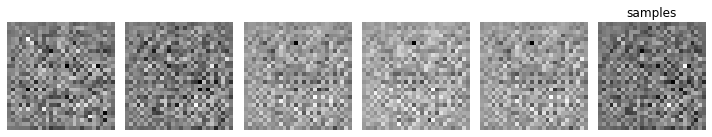

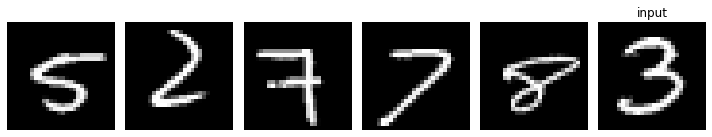

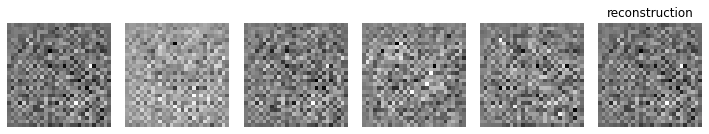

In [40]:
# Test
model = model_dict_mnist["2d_stoch"]
i = 0
for batch in train_dataset_mnist:
    callback(model, i, 42, batch)
    if i >= 0:
        break

## MNIST

Epoch 0, batch loss: 23.33114


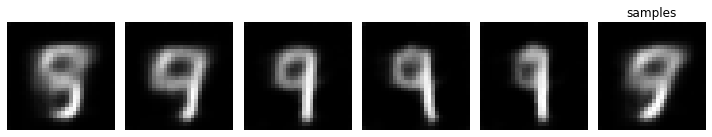

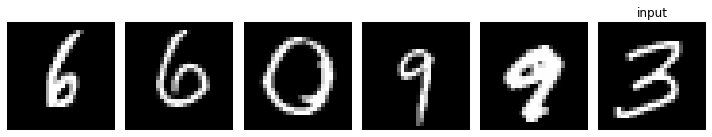

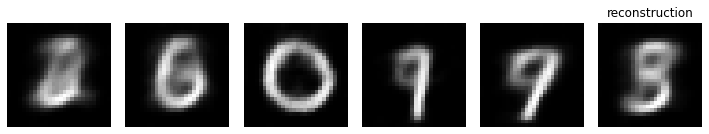

Epoch 1, batch loss: 21.86356


In [41]:
optimizer = tf.keras.optimizers.Adam(1e-3)
epochs = 2
model = model_dict_mnist["2d_det"]
model = train_model(model, optimizer, train_dataset_mnist, epochs, callback)

## CelebA

Epoch 0, batch loss: 58.01910


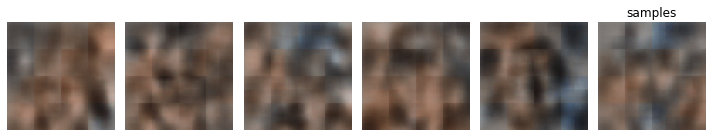

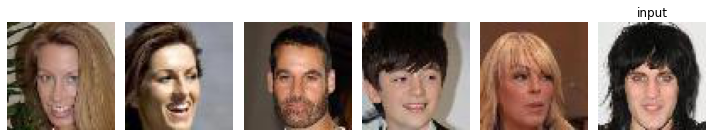

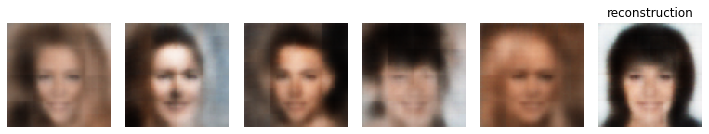

Epoch 1, batch loss: 52.51512
Epoch 2, batch loss: 42.30551
Epoch 3, batch loss: 37.13955
Epoch 4, batch loss: 43.23111
Epoch 5, batch loss: 36.50845


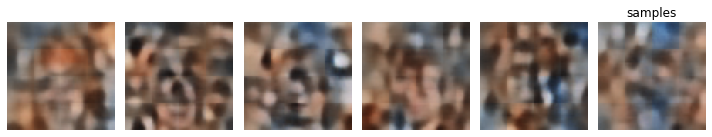

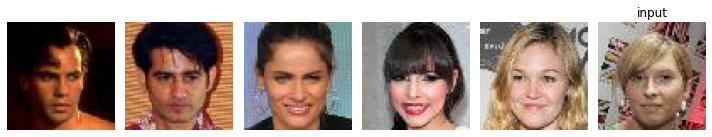

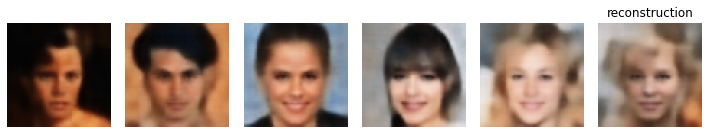

Epoch 6, batch loss: 30.98376
Epoch 7, batch loss: 38.88124
Epoch 8, batch loss: 33.50891
Epoch 9, batch loss: 35.97668
Epoch 10, batch loss: 27.43246


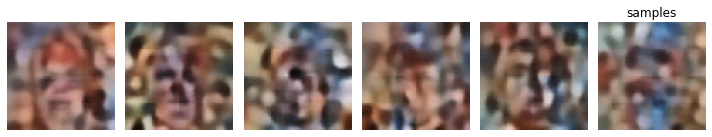

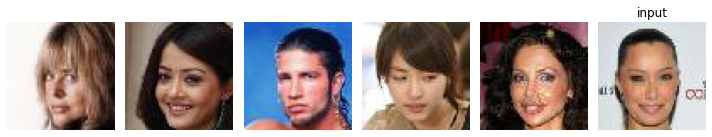

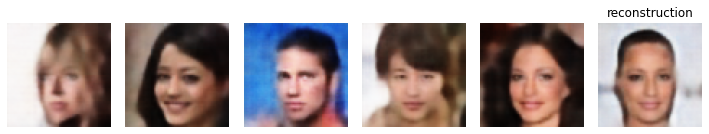

Epoch 11, batch loss: 29.74890
Epoch 12, batch loss: 30.63859
Epoch 13, batch loss: 25.41174
Epoch 14, batch loss: 35.50402
Epoch 15, batch loss: 30.08551


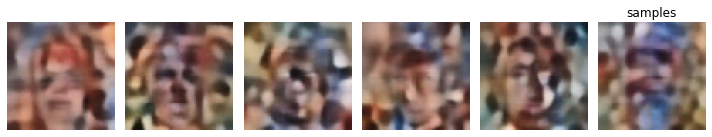

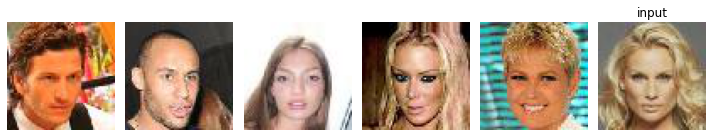

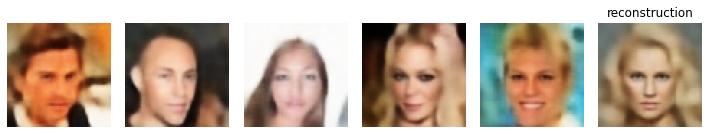

Epoch 16, batch loss: 27.59299
Epoch 17, batch loss: 32.54832
Epoch 18, batch loss: 31.27162
Epoch 19, batch loss: 30.54428


In [42]:
optimizer = tf.keras.optimizers.Adam(1e-3)
epochs = 20
model = model_dict_celeba["200d_det"]
model = train_model(model, optimizer, train_dataset_celeba, epochs, callback)

Epoch 0, batch loss: 159.00439


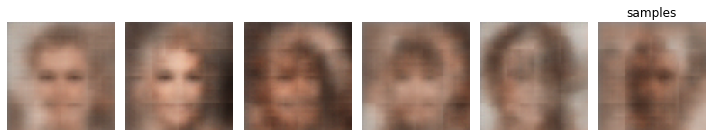

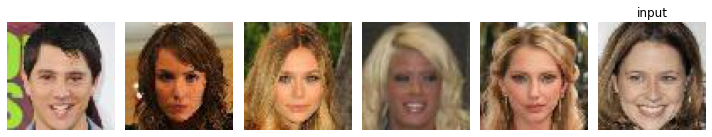

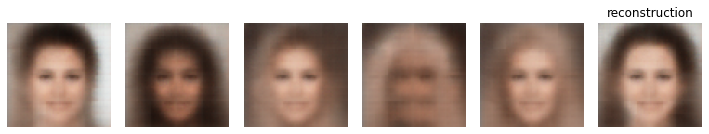

Epoch 1, batch loss: 139.15683
Epoch 2, batch loss: 122.02244
Epoch 3, batch loss: 128.59869
Epoch 4, batch loss: 120.33513
Epoch 5, batch loss: 129.05711


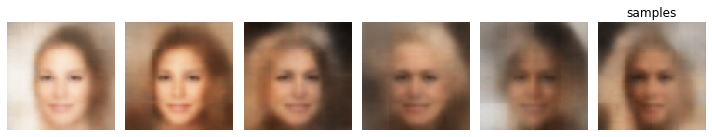

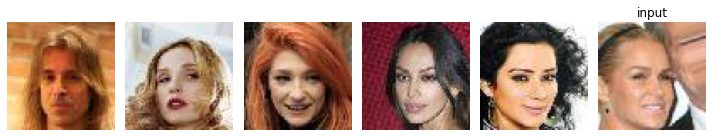

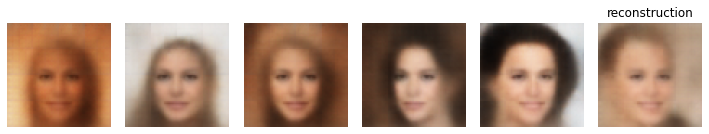

Epoch 6, batch loss: 125.26275
Epoch 7, batch loss: 127.63524
Epoch 8, batch loss: 122.34169
Epoch 9, batch loss: 109.03207
Epoch 10, batch loss: 111.89961


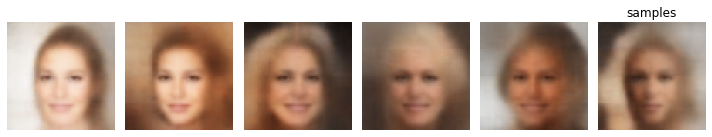

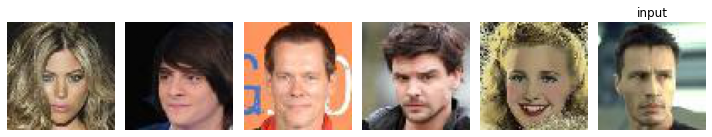

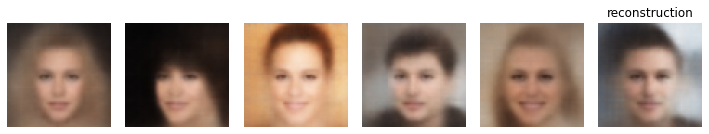

Epoch 11, batch loss: 118.08176
Epoch 12, batch loss: 127.77422
Epoch 13, batch loss: 132.63382
Epoch 14, batch loss: 115.25031
Epoch 15, batch loss: 123.18605


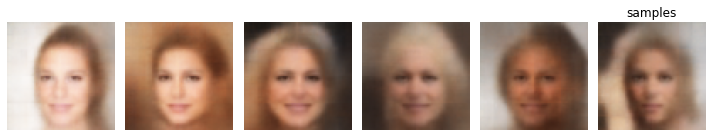

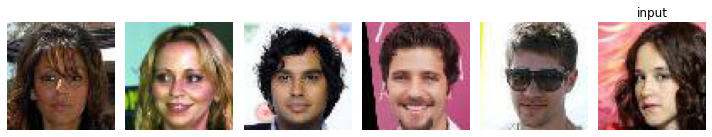

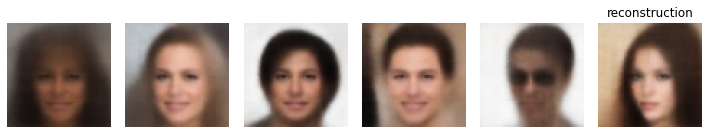

Epoch 16, batch loss: 119.97896
Epoch 17, batch loss: 116.96674
Epoch 18, batch loss: 106.08669
Epoch 19, batch loss: 111.20110


In [43]:
optimizer = tf.keras.optimizers.Adam(1e-3)
epochs = 20
model = model_dict_celeba["200d_stoch"]
model = train_model(model, optimizer, train_dataset_celeba, epochs, callback)

# Post-training

## Reconstructions

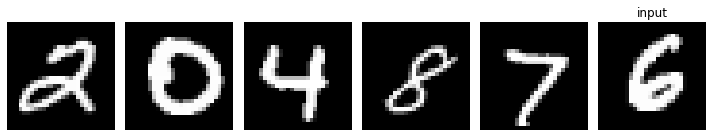

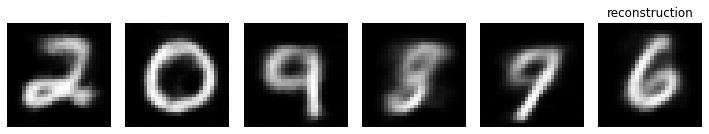

In [44]:
# generate_images(model, ttl)
model = model_dict_mnist["2d_det"]
images = images_mnist
reconstruct_images(model, images, model.model_name)

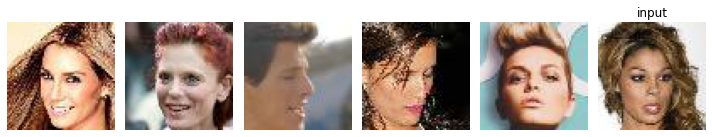

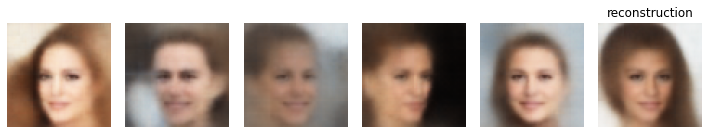

In [46]:
model = model_dict_celeba["200d_stoch"]
images = images_celeba
reconstruct_images(model, images, model.model_name)

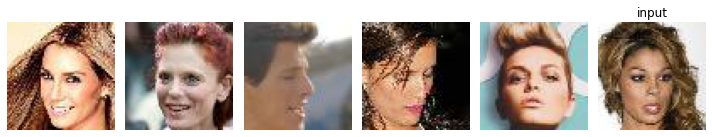

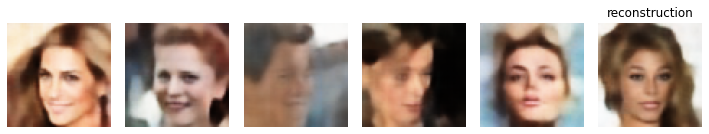

In [50]:
model = model_dict_celeba["200d_det"]
images = images_celeba
reconstruct_images(model, images, model.model_name)

## Generations

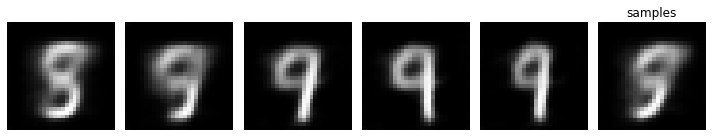

In [47]:
model = model_dict_mnist["2d_det"]
generate_images(model, model.model_name)

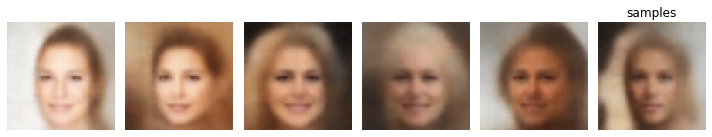

In [48]:
model = model_dict_celeba["200d_stoch"]
generate_images(model, model.model_name)

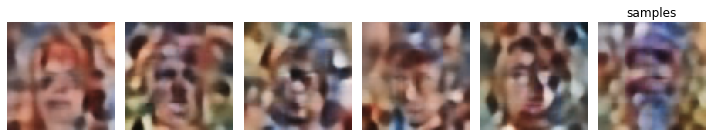

In [49]:
model = model_dict_celeba["200d_det"]
generate_images(model, model.model_name)

# Latent space analysis

Illustrate latent space embedding and arithmetic for  VAE on CelebA faces images
Code is based on 
 https://nbviewer.jupyter.org/github/davidADSP/GDL_code/blob/master/03_06_vae_faces_analysis.ipynb

In [51]:
# Make some wrapper functions so we can reuse code from
# https://github.com/davidADSP/GDL_code/blob/master/03_03_vae_faces_analysis.ipynb

N, H, W, C = images_celeba.shape
input_shape = (H, W, C)
INPUT_DIM = input_shape
DATA_FOLDER = ""
IMAGE_FOLDER = ""


def vae_encode(model, x):
    return model.encode(x)


def vae_decode(model, z_points):
    return model.decode(z_points)

In [52]:
print(input_shape)

(64, 64, 3)


In [53]:
att = pd.read_csv(csv_name)
att.head()

image_id  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  000001.jpg                -1  ...               -1      1
1  000002.jpg                -1  ...               -1      1
2  000003.jpg                -1  ...               -1      1
3  000004.jpg                -1  ...               -1      1
4  000005.jpg                -1  ...               -1      1

[5 rows x 41 columns]

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class ImageLabelLoader:
    def __init__(self, image_folder, target_size):
        self.image_folder = image_folder
        self.target_size = target_size

    def build(self, att, batch_size, label=None):

        data_gen = ImageDataGenerator(rescale=1.0 / 255)
        if label:
            data_flow = data_gen.flow_from_dataframe(
                att,
                self.image_folder,
                x_col="image_id",
                y_col=label,
                target_size=self.target_size,
                class_mode="raw",  # other
                batch_size=batch_size,
                shuffle=True,
            )
        else:
            data_flow = data_gen.flow_from_dataframe(
                att,
                self.image_folder,
                x_col="image_id",
                target_size=self.target_size,
                class_mode="input",
                batch_size=batch_size,
                shuffle=True,
            )

        return data_flow

In [55]:
imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])

## Arithmetic in latent space

In [56]:
def get_vector_from_label(model, label, batch_size=500, att=att):
    latent_dim = model.latent_dim
    data_flow_label = imageLoader.build(att, batch_size, label=label)

    # origin = np.zeros(shape = latent_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape=latent_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=latent_dim, dtype="float32")

    current_sum_NEG = np.zeros(shape=latent_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=latent_dim, dtype="float32")

    current_vector = np.zeros(shape=latent_dim, dtype="float32")
    current_dist = 0

    print("label: " + label)
    print("images : POS move : NEG move :distance : 𝛥 distance")
    while current_n_POS < 10000:

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]
        z = vae_encode(model, np.array(im))

        z_POS = z[attribute == 1]
        z_NEG = z[attribute == -1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(
            str(current_n_POS)
            + "    : "
            + str(np.round(movement_POS, 3))
            + "    : "
            + str(np.round(movement_NEG, 3))
            + "    : "
            + str(np.round(new_dist, 3))
            + "    : "
            + str(np.round(dist_change, 3))
        )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break

    return current_vector

In [57]:
def add_vector_to_images(example_images, model, feature_vec, att=att):
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    # factors = [-4,-2,0,2,4]
    n_to_show = len(example_images)
    z_points = vae_encode(model, example_images)
    for i in range(n_to_show):
        fig = plt.figure(figsize=(18, 8))
        counter = 1
        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis("off")
        sub.imshow(img)
        counter += 1
        for factor in factors:
            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae_decode(model, np.array([changed_z_point]))[0]
            img = changed_image.numpy().squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis("off")
            sub.imshow(img)
            counter += 1
        plt.show()

In [58]:
print("Eyeglasses Vector")
# model = model_dict_celeba['200d_stoch']
model = model_dict_celeba["200d_det"]
eyeglasses_vec = get_vector_from_label(model, "Eyeglasses")

Eyeglasses Vector
Found 20000 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
26    : 5.672    : 4.865    : 4.928    : 4.928
65    : 2.957    : 0.57    : 3.584    : -1.343
94    : 1.372    : 0.304    : 3.584    : -0.001
121    : 0.707    : 0.282    : 3.384    : -0.2
152    : 0.61    : 0.17    : 3.3    : -0.084
185    : 0.533    : 0.142    : 3.308    : 0.008
222    : 0.576    : 0.097    : 3.293    : -0.015
259    : 0.37    : 0.144    : 3.287    : -0.005
293    : 0.351    : 0.083    : 3.252    : -0.035
331    : 0.319    : 0.077    : 3.29    : 0.038
360    : 0.288    : 0.094    : 3.304    : 0.013
392    : 0.263    : 0.055    : 3.372    : 0.068
421    : 0.317    : 0.072    : 3.353    : -0.019
450    : 0.282    : 0.056    : 3.31    : -0.043
477    : 0.296    : 0.085    : 3.33    : 0.02
506    : 0.198    : 0.051    : 3.347    : 0.017
539    : 0.186    : 0.052    : 3.331    : -0.016
572    : 0.158    : 0.044    : 3.358    : 0.027
610    : 0.188

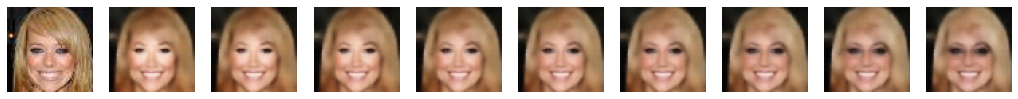

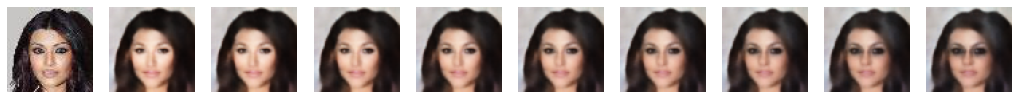

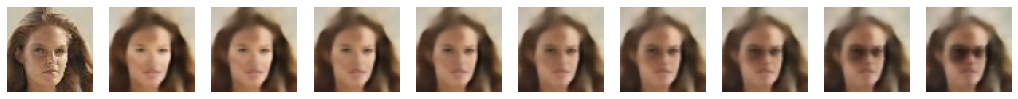

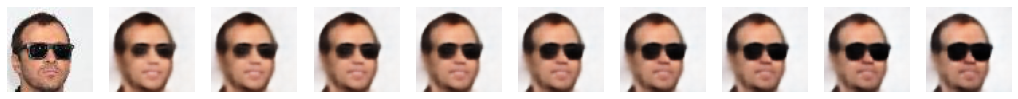

In [59]:
ndx = [112 - 1, 258 - 1, 238 - 1, 193 - 1]  # blonde, black hair, brunette, male with glasses
add_vector_to_images(images_celeba[ndx], model, eyeglasses_vec)

In [60]:
print("Male Vector")
male_vec = get_vector_from_label(model, "Male")

Male Vector
Found 20000 validated image filenames.
label: Male
images : POS move : NEG move :distance : 𝛥 distance
196    : 4.363    : 5.328    : 3.292    : 3.292
413    : 0.871    : 0.589    : 3.081    : -0.211
633    : 0.479    : 0.356    : 3.005    : -0.076
827    : 0.288    : 0.283    : 2.889    : -0.116
1043    : 0.309    : 0.267    : 2.897    : 0.008
1258    : 0.223    : 0.173    : 2.956    : 0.058
1474    : 0.169    : 0.144    : 2.979    : 0.024
1678    : 0.152    : 0.156    : 2.981    : 0.002
1891    : 0.127    : 0.095    : 3.016    : 0.035
2109    : 0.123    : 0.085    : 3.01    : -0.006
2336    : 0.118    : 0.075    : 2.999    : -0.011
2547    : 0.102    : 0.083    : 2.997    : -0.002
2742    : 0.098    : 0.072    : 3.011    : 0.014
2959    : 0.097    : 0.07    : 3.027    : 0.016
3164    : 0.084    : 0.07    : 3.018    : -0.009
3351    : 0.073    : 0.057    : 3.038    : 0.02
3542    : 0.059    : 0.061    : 3.046    : 0.008
3742    : 0.057    : 0.049    : 3.051    : 0.004
3957

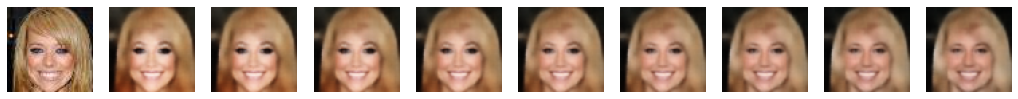

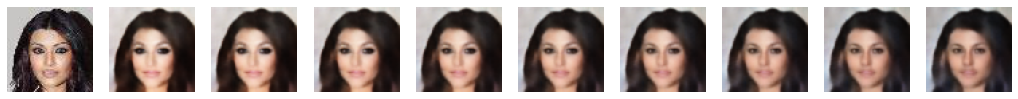

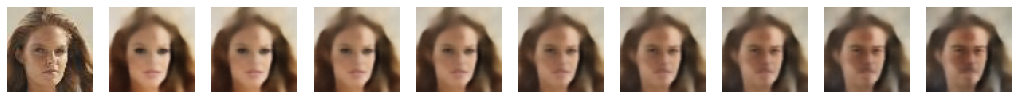

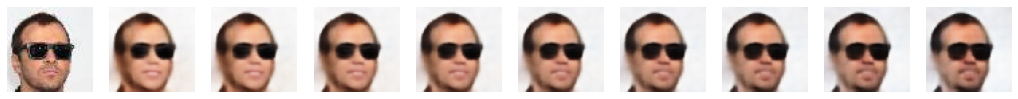

In [61]:
ndx = [112 - 1, 258 - 1, 238 - 1, 193 - 1]  # blonde, black hair, brunette, male with glasses
add_vector_to_images(images_celeba[ndx], model, male_vec)

## Face interpolation

In [62]:
def morph_faces(start_image, end_image, model):
    # factors = np.arange(0, 1, 0.1)
    factors = np.arange(0, 1, 0.2)
    example_images = np.stack((start_image, end_image), 0)

    z_points = vae_encode(model, example_images)

    fig = plt.figure(figsize=(18, 8))

    counter = 1
    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    counter += 1
    for factor in factors:

        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = vae_decode(model, np.array([changed_z_point]))[0]

        img = changed_image.numpy().squeeze()
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    plt.show()

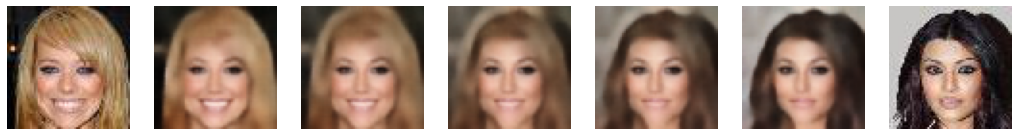

In [63]:
# model = model_dict_celeba['200d_stoch']
model = model_dict_celeba["200d_det"]
start_image = images_celeba[112 - 1]  # blonde
end_image = images_celeba[258 - 1]  # brunette
morph_faces(start_image, end_image, model)

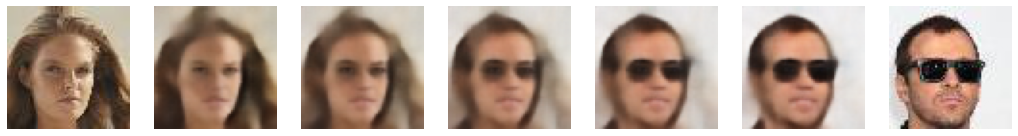

In [64]:
start_image = images_celeba[238 - 1]  # female
end_image = images_celeba[193 - 1]  # male, glasses
morph_faces(start_image, end_image, model)